# Style-Transfer with Pytorch
Code taken from [NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=style%20transfer).

## 1. Setup:

### 1.1. Import libs

In [41]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

import torchvision.models as models

import copy

import numpy as np

### 1.2. Choose machine

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.3. Define the desired size of the output image
Don't go too high 'cause this may stress your machine. Start small and work your way up, benchmarking your machine at the same time.

In [83]:
imsize = 512 if torch.cuda.is_available() else 512  # use small size if no gpu

## 2. Load Image

### 2.1. Import and Rescale image
The `loader` simply imports the provided image and does a bit of resizing based on the `imsize` value. Then converts the image into a tensor. 

In [84]:
loader = transforms.Compose([
    transforms.Resize(imsize), # scale imported image
    transforms.ToTensor()])    # transform it into a torch tensor

We use a helper function to actually apply the loader onto the images we want to process:

In [85]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

For the purpose of this demontration I will use an image that represents the famous fortress of Koules. The Koules or Castello a Mare is a fortress located at the entrance of the old port of Heraklion, Crete, Greece. It was built by the Republic of Venice in the early 16th century, and is still in good condition today. A picture appears below:
![Koules](content_images/koules.jpg)

In [86]:
# Let's go ahead and load it
content_img = image_loader("content_images/koules.jpg")

As for the style, i will use a painting that I think will generate some interesting results; the Rain's Rustle II. This brightly colored depiction of a romantic stroll dispels myths associated with gloomy rain, as "Rain's Rustle II" presents an atmosphere of life and anticipation. Glistening pools of rainfall blanket the weaving pathway, reflecting the glimmers of light from ornate lamp posts. The tone and color of the leaves reveal the movement of the wind, creating a serene accent to your living room or office.
![Rain's Rustle](style_images/rains_rustle.jpg)

In [87]:
style_img = image_loader("style_images/rains_rustle.jpg")

Here comes the first issue. If you are trying to do this on your own, using your own images as I am, then the following assertion won't work.

In [88]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

AssertionError: we need to import style and content images of the same size

This is to be expected, given that:

In [89]:
print(style_img.size())

torch.Size([1, 3, 512, 816])


In [90]:
print(content_img.size())

torch.Size([1, 3, 512, 768])


This seems weird given the resizing applied in the data loader. However, the resizing assumes that the dimensions ratio of the input images is the same, i.e. for $p$, the content image and $s$, the style image:

$\frac{p_{width}}{p_{heightt}} = \frac{s_{width}}{s_{heightt}}$

But this is not the case:

In [91]:
content_image = Image.open("content_images/koules.jpg")

In [92]:
p_ratio = content_image.width/content_image.height
print("p_ratio={}".format(p_ratio))

p_ratio=1.5


In [93]:
style_image = Image.open("style_images/rains_rustle.jpg")

In [94]:
s_ratio = style_image.width/style_image.height
print("p_ratio={}".format(s_ratio))

p_ratio=1.594896331738437


So, we need to play around a bit with the dimensions of the style image to adjust this.

In [95]:
style_image = ImageOps.fit(style_image, (content_image.width, content_image.height))   # PIL.ImageOps.fit(image, size, method=0, bleed=0.0, centering=(0.5, 0.5)) where size – The requested output size in pixels, given as a (width, height) tuple.

Then following up on the remainign operations of then data loader helper:

In [96]:
style_img_unsqueezed = loader(style_image).unsqueeze(0)
style_img = style_img_unsqueezed.to(device, torch.float)

The style image is now, not only resized but has an equal ratio to the content image:

In [97]:
print(style_img.size())

torch.Size([1, 3, 512, 768])


In [98]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

It's always useful to visualise the process in all steps. To do that we need to be able to convert our tensor back to an image:

In [99]:
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

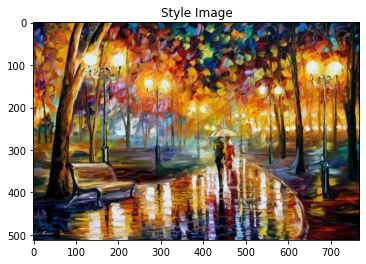

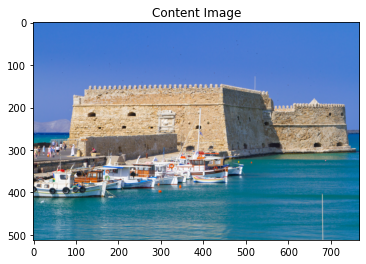

In [100]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1. Content Loss
For the content loss, what we are looking into is the mean squared error between a high-level layer and the input image (line 12). The input is the image we are trying to update in order to generate the final output. Loss there is a `nn.Module`. 

In [101]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### 3.2. Style Loss
As explained, for the gram matrix we produce the inner product of the feature-maps followed up by a normalisation operation. 

In [102]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Finally for the style-loss we get the gram matrix and store under `self.target` in order to the produce a mean-squared-error against `G`. So practically, `self.target` is $\overrightarrow{a}$ in our equation.

In [103]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 4. Importing the Model
The model is pre-trained and it is quite big. We just want to use it as is. It may take some time to download.

In [66]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/chadjinik/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. They are used to normalize the image before sending it into the network.

In [104]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In the tutorial, a module is created to normalize input image so we can easily put it in a `nn.Sequential`

In [105]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

As per the tutorial:
>A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

As part of that, we need to choose the high-level layer that we want to use. The authors choose layer 4 for the content. At the same time, 5 layers are used for the style. 

In [106]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Next we have a quite central piece of code, that puts ecerything together. 

* [line 5] We copy the cnn (don't want to alter the original one).
* [line 8] We apply normalistaion on the `mean` and `std` values.
* [lines 12-13] We create our arraylists for the content and style losses.
* [line 17] We modify the model by using sequential, dictating that modules are activated sequentially.
* [line 19 onwards] The model is practically tweaked in order to generate images--rather than identify objects which is its primary use. The loop goes through every layer and depending on its kind, it applies different operations to get all the module names and add them in the model [line 37].
* [line 39 onwards] Depending on whether we are concerned with a content layer or a style layer `content_loss` and `style_loss` are respectively updated and the new values are appendend to the arraylists previously created. 

In [107]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image or white noise.

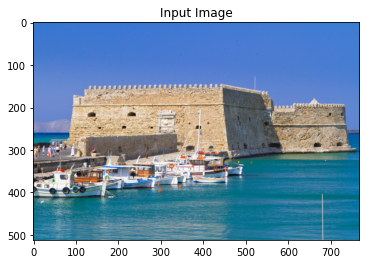

In [108]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

## 5. Gradient Descent

Finally, we get to the mother of all ML algorithms "gradient descent"! here is where everything takes place. 

Remember that: 
>...unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [109]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

> Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

> We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [110]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=100):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## 6. Let's run it

Building the style transfer model..


<ipython-input-105-6bc786d3aaa8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-105-6bc786d3aaa8>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 191.307571 Content Loss: 24.822777

run [100]:
Style Loss : 66.978317 Content Loss: 26.329695

run [150]:
Style Loss : 26.926384 Content Loss: 25.695587

run [200]:
Style Loss : 15.670465 Content Loss: 23.341522

run [250]:
Style Loss : 11.384161 Content Loss: 20.864159

run [300]:
Style Loss : 8.371198 Content Loss: 19.419767



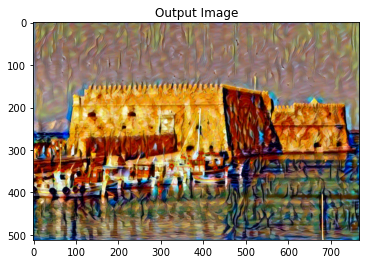

In [111]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

As you see, the output is not so much great... There are many things you can try to improve it. 
1. Use a white-noise image rather than the content image for a starting point.
2. Increase the image analysis for 128 to 256 or 512
3. Play with the `style_weight=1000000` and `content_weight=1` values. 

After a bit of tweaking and playing around I am sure that you can get it right. 

Have a look at some of the images I produced back at my [article](https://christos-hadjinikolis.github.io//2020/08/15/on-style-transfer.html)|!

In [ ]:
# THE END